In [163]:
import pandas as pd 
import numpy as np
import sys, os

from tqdm import notebook 
from tqdm import tqdm

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import matplotlib.pyplot as plt

In [54]:
ROOT = '../../'
DATA_PATH = os.path.join(os.path.join(ROOT, '04 select feature and build model'), 'data')
CLEANED_FACTOR_PATH = os.path.join(ROOT, '03 data process')

sys.path.append(os.path.join(ROOT, '04 select feature and build model'))
from load_data import load_data, plot_rts


# Lets try Trista's CODE

你的圖
真的醜欸

C:\ProgramData\Anaconda3\envs\env_mlf\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


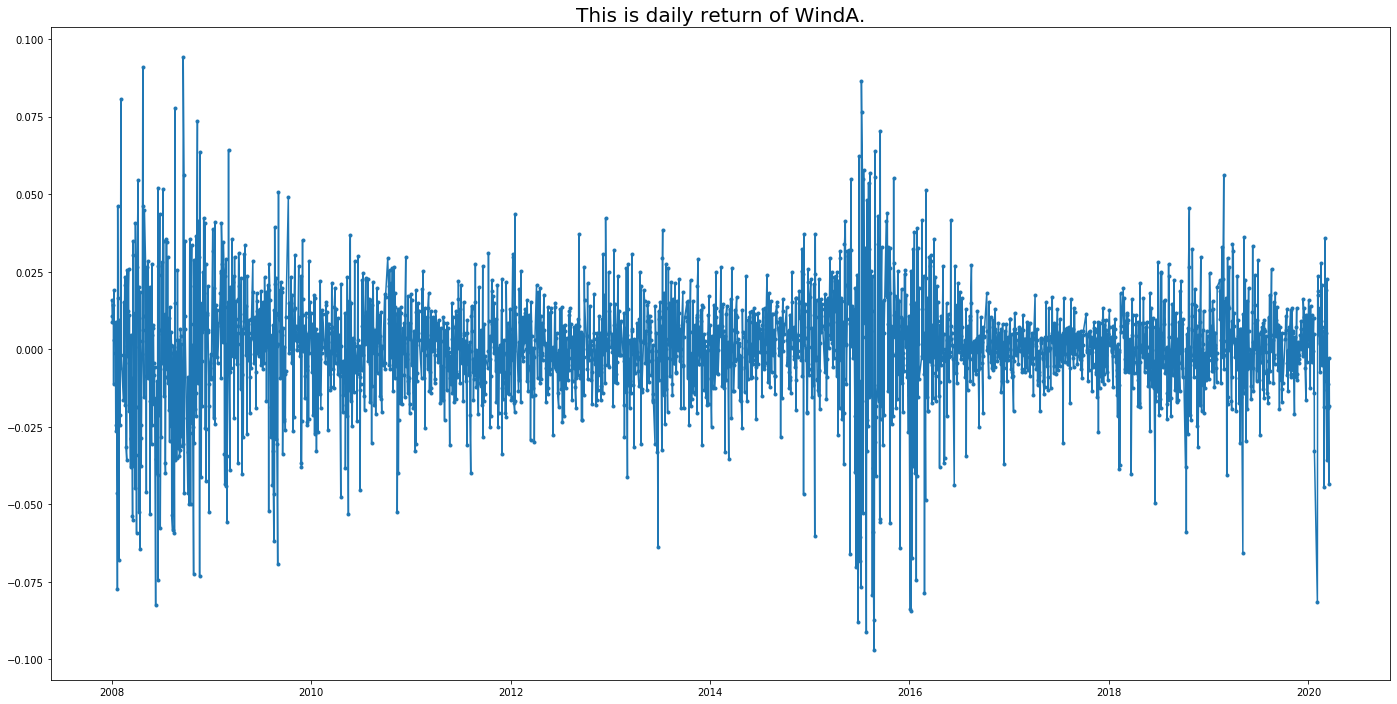

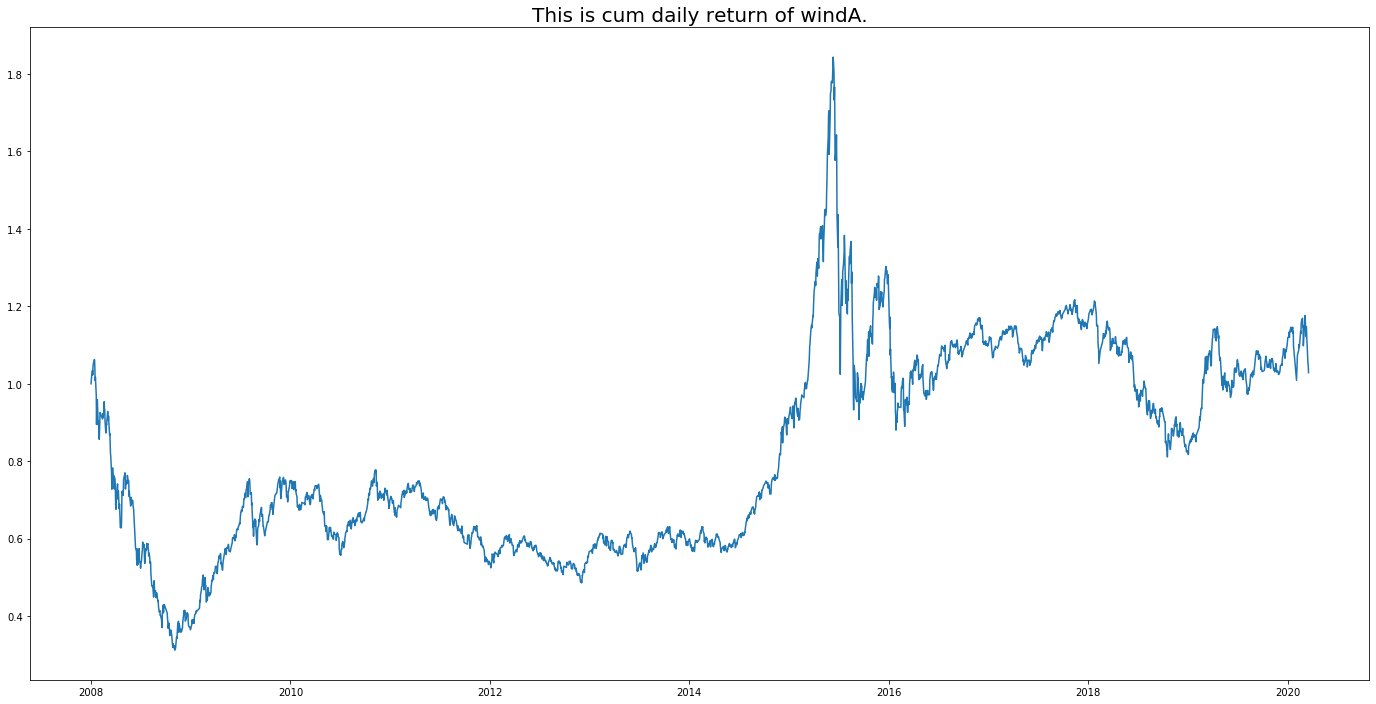

In [16]:
windADf = load_data(DATA_PATH + '/881001.csv')
plot_rts(windADf)

In [84]:
rawDf = pd.read_pickle(os.path.join(CLEANED_FACTOR_PATH, 'cleanedFactor.pkl'))
rawXs, rawYs = rawDf.iloc[:, :-4], rawDf.iloc[:, -1].astype(bool)
rawYs

date
2008-04-01    False
2008-04-02     True
2008-04-03     True
2008-04-07     True
2008-04-08    False
              ...  
2020-03-02     True
2020-03-03     True
2020-03-04     True
2020-03-05    False
2020-03-06    False
Name: windATomorrowUp, Length: 2903, dtype: bool

In [85]:
def feature_selection(X_train, y_train, X_test, y_test, method = None, returnCoef = False):
    
    '''
    choose the model type with method
    fit any feature_selection model with the X_train, y_train
    transform the X_train, X_test with the model
    do not use the X_test to build feature selection model
    
    return the selected X_train, X_test
    print info of the selecter
    return the coef or the score of each feature if asked
    
    '''
    if not returnCoef:
        return(X_train, X_test)
    else:
        return(X_train, X_test, pd.Series())

# Init some parameter to for single period test

In [155]:
START_DATE = str(rawYs.index[0].date())
END_DATE = str(rawYs.index[-1].date())

change_hand_dates = pd.date_range(START_DATE, END_DATE,freq = "20B")


In [87]:
TRAIN_MODE = 'extention'

In [88]:
predictStartDate = change_hand_dates[-2]
predictEndDate = change_hand_dates[-1]

if TRAIN_MODE == 'extention':
    trainStartDate = START_DATE
elif TRAIN_MODE == 'rolling':
    trainStartDate = predictStartDate-pd.Timedelta(1800, unit = 'd')

print('predict from {} to {}'.format(period_start_date.date(), period_end_date.date()))

predict from 2020-01-29 to 2020-02-18


# Single period TEST

In [89]:
X_train, y_train = rawXs[trainStartDate:predictStartDate], rawYs[trainStartDate:predictStartDate]
print(X_train.shape, y_train.shape)

X_test, y_test = rawXs[predictStartDate:predictEndDate], rawYs[predictStartDate:predictEndDate]
print(X_test.shape, y_test.shape)

(2878, 47) (2878,)
(12, 47) (12,)


In [90]:
X_train_selected, X_test_selected = feature_selection(X_train, y_train, X_test, y_test)

In [95]:
predictModel = DecisionTreeClassifier

In [96]:
model = predictModel()
model.fit(X_train_selected, y_train)
pd.Series(model.predict(X_test_selected), index = y_test.index)

date
2020-02-03    False
2020-02-04     True
2020-02-05     True
2020-02-06    False
2020-02-07    False
2020-02-10     True
2020-02-11    False
2020-02-12    False
2020-02-13     True
2020-02-14     True
2020-02-17    False
2020-02-18     True
dtype: bool

#  Let's roll

In [224]:
# input 
MIN_TRAIN_DAYS = 1800
TRAIN_MODE = 'extention'
predictModel = DecisionTreeClassifier
recordModels = True
# output
modelRecord = {}
outputPrediction = pd.Series()

In [225]:
for predictStartDate, predictEndDate in notebook.tqdm(zip(change_hand_dates, change_hand_dates[1:])):
    tqdm.write('start predict from {} to {}'.format(predictStartDate, predictEndDate))
    trainDataDays = np.busday_count(np.datetime64(START_DATE), np.datetime64(predictStartDate.date()))
    if trainDataDays < MIN_TRAIN_DAYS:
        tqdm.write('We only have {} trainDataDays'.format(trainDataDays))
        continue
    
    if TRAIN_MODE == 'extention':
        trainStartDate = START_DATE
    elif TRAIN_MODE == 'rolling':
        trainStartDate = predictStartDate-pd.Timedelta(MIN_TRAIN_DAYS, unit = 'B')
    
    
    X_train, y_train = rawXs[trainStartDate:predictStartDate], rawYs[trainStartDate:predictStartDate]
    tqdm.write('train shape (X, y):{}'.format(X_train.shape, y_train.shape))
    X_test, y_test = rawXs[predictStartDate:predictEndDate], rawYs[predictStartDate:predictEndDate]
    tqdm.write('test  shape (X, y):{}'.format(X_test.shape, y_test.shape))
    
    # %% feature selection 
    X_train_selected, X_test_selected = feature_selection(X_train, y_train, X_test, y_test)

    # fit predict
    model = predictModel()
    model.fit(X_train_selected, y_train)
    
    y_true = y_test
    y_pred = model.predict(X_test_selected)
    
    tqdm.write("precision:{}".format(metrics.precision_score(y_true, y_pred)))
    tqdm.write("recall:{}".format(metrics.recall_score(y_true, y_pred)))
    tqdm.write("f1:{}\n".format(metrics.f1_score(y_true, y_pred)))  
    
    y_predictSeries = pd.Series(y_pred, index = y_test.index)
    
    #  concat outputs
    outputPrediction = pd.concat([outputPrediction, y_predictSeries])    
    if recordModels:
        modelRecord.update({
            str(predictStartDate.date()):{
                'trainStartDate' :trainStartDate,
                'predictStartDate' :predictStartDate,
                'predictEndDate' :predictEndDate, 
                'model' :model 
            }           
        })

    
    

start predict from 2008-04-01 00:00:00 to 2008-04-29 00:00:00
We only have 0 trainDataDays
start predict from 2008-04-29 00:00:00 to 2008-05-27 00:00:00
We only have 20 trainDataDays
start predict from 2008-05-27 00:00:00 to 2008-06-24 00:00:00
We only have 40 trainDataDays
start predict from 2008-06-24 00:00:00 to 2008-07-22 00:00:00
We only have 60 trainDataDays
start predict from 2008-07-22 00:00:00 to 2008-08-19 00:00:00
We only have 80 trainDataDays
start predict from 2008-08-19 00:00:00 to 2008-09-16 00:00:00
We only have 100 trainDataDays
start predict from 2008-09-16 00:00:00 to 2008-10-14 00:00:00
We only have 120 trainDataDays
start predict from 2008-10-14 00:00:00 to 2008-11-11 00:00:00
We only have 140 trainDataDays
start predict from 2008-11-11 00:00:00 to 2008-12-09 00:00:00
We only have 160 trainDataDays
start predict from 2008-12-09 00:00:00 to 2009-01-06 00:00:00
We only have 180 trainDataDays
start predict from 2009-01-06 00:00:00 to 2009-02-03 00:00:00
We only have 2

precision:0.85
recall:1.0
f1:0.9189189189189189

start predict from 2015-03-24 00:00:00 to 2015-04-21 00:00:00
train shape (X, y):(1695, 47)
test  shape (X, y):(20, 47)
precision:0.7058823529411765
recall:0.8571428571428571
f1:0.7741935483870968

start predict from 2015-04-21 00:00:00 to 2015-05-19 00:00:00
train shape (X, y):(1714, 47)
test  shape (X, y):(20, 47)
precision:0.6666666666666666
recall:0.42857142857142855
f1:0.5217391304347826

start predict from 2015-05-19 00:00:00 to 2015-06-16 00:00:00
train shape (X, y):(1733, 47)
test  shape (X, y):(21, 47)
precision:0.8125
recall:0.7647058823529411
f1:0.787878787878788

start predict from 2015-06-16 00:00:00 to 2015-07-14 00:00:00
train shape (X, y):(1753, 47)
test  shape (X, y):(20, 47)
precision:0.38461538461538464
recall:0.625
f1:0.4761904761904762

start predict from 2015-07-14 00:00:00 to 2015-08-11 00:00:00
train shape (X, y):(1772, 47)
test  shape (X, y):(21, 47)
precision:0.6666666666666666
recall:0.18181818181818182
f1:0.28

precision:0.23076923076923078
recall:0.375
f1:0.2857142857142857

start predict from 2018-08-07 00:00:00 to 2018-09-04 00:00:00
train shape (X, y):(2521, 47)
test  shape (X, y):(21, 47)
precision:0.5
recall:0.5
f1:0.5

start predict from 2018-09-04 00:00:00 to 2018-10-02 00:00:00
train shape (X, y):(2541, 47)
test  shape (X, y):(18, 47)
precision:0.36363636363636365
recall:0.5714285714285714
f1:0.4444444444444444

start predict from 2018-10-02 00:00:00 to 2018-10-30 00:00:00
train shape (X, y):(2558, 47)
test  shape (X, y):(17, 47)
precision:0.42857142857142855
recall:0.75
f1:0.5454545454545454

start predict from 2018-10-30 00:00:00 to 2018-11-27 00:00:00
train shape (X, y):(2575, 47)
test  shape (X, y):(21, 47)
precision:0.5555555555555556
recall:0.45454545454545453
f1:0.5

start predict from 2018-11-27 00:00:00 to 2018-12-25 00:00:00
train shape (X, y):(2595, 47)
test  shape (X, y):(21, 47)
precision:0.6
recall:0.6666666666666666
f1:0.631578947368421

start predict from 2018-12-25 0

In [226]:
modelRecord

{'2015-02-24': {'trainStartDate': '2008-04-01',
  'predictStartDate': Timestamp('2015-02-24 00:00:00', freq='20B'),
  'predictEndDate': Timestamp('2015-03-24 00:00:00', freq='20B'),
  'model': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='best')},
 '2015-03-24': {'trainStartDate': '2008-04-01',
  'predictStartDate': Timestamp('2015-03-24 00:00:00', freq='20B'),
  'predictEndDate': Timestamp('2015-04-21 00:00:00', freq='20B'),
  'model': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                   

# Try to plot it out

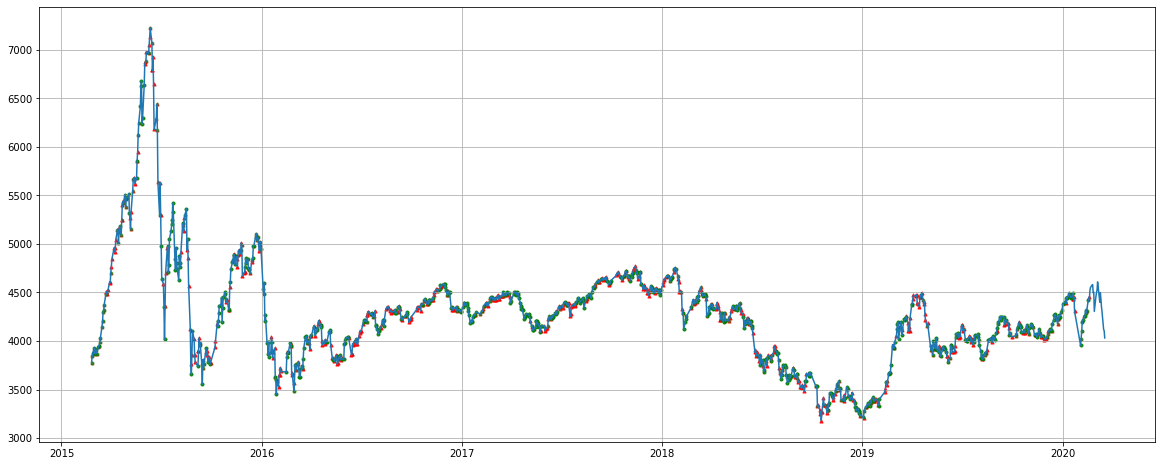

In [217]:
# indexClose = windADf.loc[:, ['date', 'close']].set_index('date')

indexClose = windADf.loc[:, ['date', 'close']].set_index('date')
indexClose = indexClose[outputPrediction.index[0]:]


plt.figure(figsize = (20, 8))
plt.grid()
plt.plot(indexClose.index, indexClose.close)
plt.scatter(indexClose.loc[outputPrediction.index[outputPrediction]].index, indexClose.loc[outputPrediction.index[outputPrediction]], marker = '^', color = 'r', s = 8, alpha = 0.3)
plt.scatter(indexClose.loc[outputPrediction.index[~outputPrediction]].index, indexClose.loc[outputPrediction.index[~outputPrediction]], color = 'g', s = 8 , alpha = 0.3)

plt.show()
